# Regression Project

## GOALS:

## IMPORTS

In [1]:
# Standard imports
import numpy as np
import pandas as pd

# My imports
import wrangle as w
import explore as e
import modeling as m

from pydataset import data
from scipy import stats


import matplotlib.pyplot as plt
import seaborn as sns

# Stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor
from sklearn.linear_model import LassoLars
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector


# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## AQUIRE, PREPARE AND SPLIT DATA

In [2]:
df, prep_df = w.get_zillow_data()

csv file found and loaded


In [3]:
df.shape

(49251, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49251 entries, 0 to 52440
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bedrooms        49251 non-null  int64  
 1   bathrooms       49251 non-null  float64
 2   area            49251 non-null  int64  
 3   yearbuilt       49251 non-null  int64  
 4   county          49251 non-null  object 
 5   county_Orange   49251 non-null  uint8  
 6   county_Ventura  49251 non-null  uint8  
 7   property_value  49251 non-null  int64  
dtypes: float64(1), int64(4), object(1), uint8(2)
memory usage: 2.7+ MB


In [5]:
target = 'property_value'

In [6]:
tr, val, ts = w.get_split(df)

In [7]:
tr.shape, val.shape, ts.shape

((29550, 8), (9850, 8), (9851, 8))

In [8]:
# tr_smpl = tr.sample(10_000)
tr_smpl = tr

In [9]:
# e.plot_variable_pairs(tr_smpl)

## 1. Does the location of a property impact its assessed value?

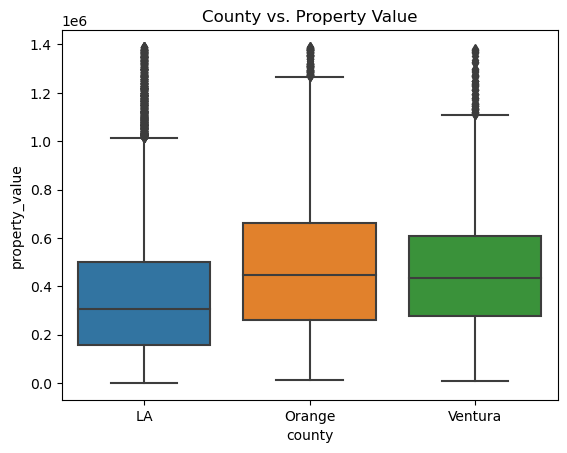

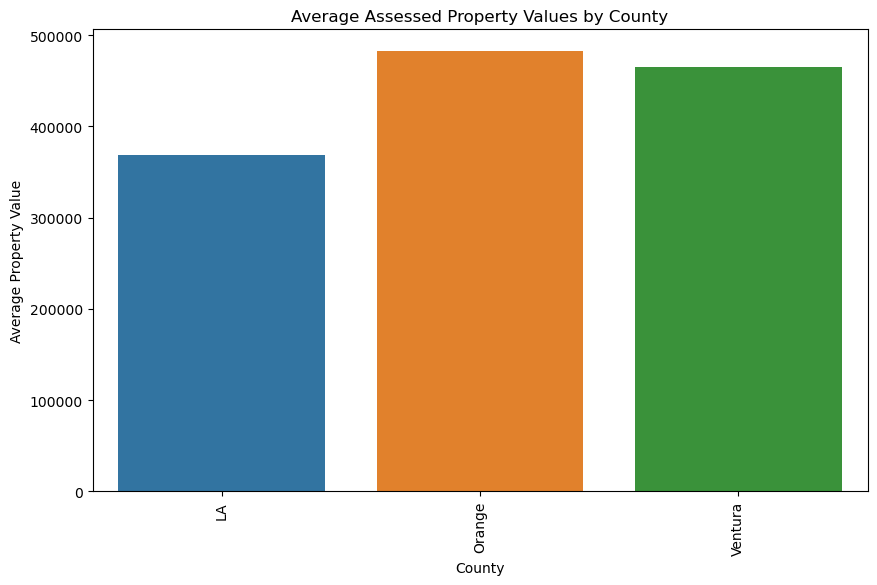

In [10]:
e.get_qone_chart(tr_smpl)

Hypothesis Test:
>Null Hypothesis (H0): The location of a property does not have a significant impact on its assessed value.

>Alternative Hypothesis (HA): The location of a property has a significant impact on its assessed value.

For ANOVA:
>H0: The mean assessed values of properties are equal across different locations.

>HA: The mean assessed values of properties are not equal across different locations.

For Kruskal-Wallis:
>H0: The assessed values of properties are equal across different locations.

>HA: The assessed values of properties are not equal across different locations.

In [11]:
# Perform one-way ANOVA and Kruskal-Wallis test
e.get_anova_n_kruskal_test(tr_smpl)

ANOVA - p-value: 2.337395898492942e-217
We reject the null hypothesis

Kruskal-Wallis - p-value: 1.1514863965471243e-264
We reject the null hypothesis


### Summary:

The location assessed value matter of where you choose to live. Orange county has the highest property value and LA the lowest. 

## 2. How does the square footage of a property relate to its assessed value?

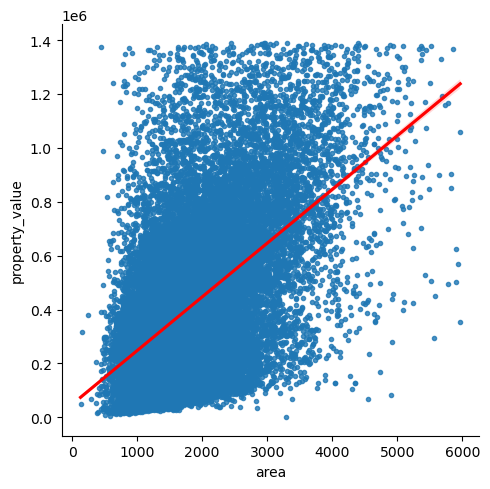

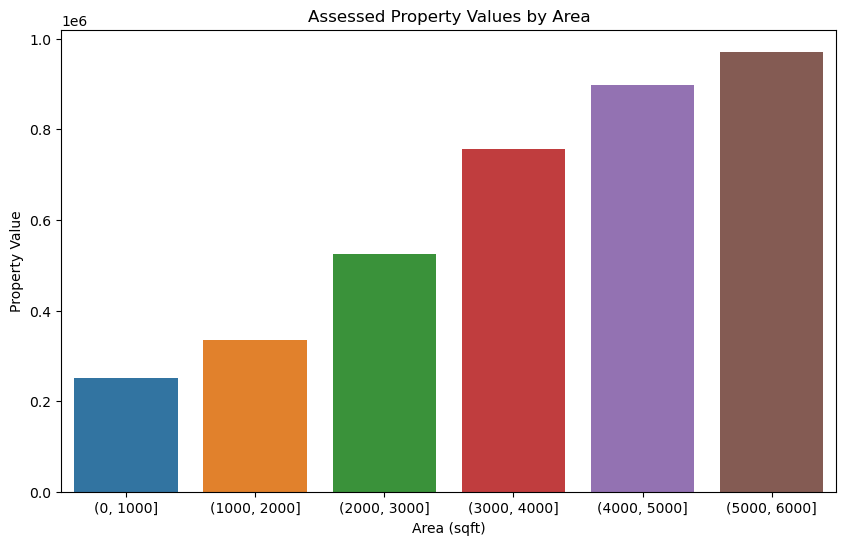

In [12]:
e.get_qtwo_chart(tr_smpl)

>Null Hypothesis (H0): There is NO significant correlation between the square footage of a property and its assessed value.

>Alternative Hypothesis (HA): There IS a significant correlation between the square footage of a property and its assessed value.

In [13]:
e.get_qtwo_stats(tr_smpl)

Pearson correlation - p-value: 0.0
We reject the null hypothesis

Correlation between area and property value
  r = 0.5286


### Summary:

There is a significant difference between the area of a property and the value. 

## 3. What is the relationship between the number of bedrooms/bathrooms and the assessed value?

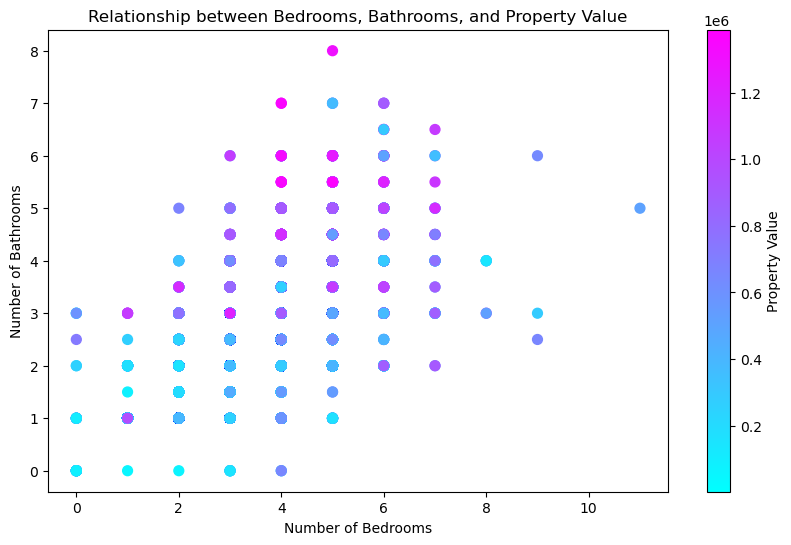

In [14]:
e.get_qthree_chart(tr_smpl)

>Null Hypothesis (H0): There is NO relationship between the number of bedrooms/bathrooms and the property value.

>Alternative Hypothesis (HA): There is a relationship between the number of bedrooms/bathrooms and the property value.

In [15]:
e.get_qthree_stats(tr_smpl)


ANOVA - p-value: 0.0
We reject the null hypothesis



,bedrooms,bathrooms,property_value
bedrooms,1.000000,0.627598,0.264334
bathrooms,0.627598,1.000000,0.462810
property_value,0.264334,0.462810,1.000000


### Summary:

Properties with a higher number of bedrooms or bathrooms have a significantly different assessed value compared to properties with fewer bedrooms or bathrooms.

### 4. Does the year built of a property affect its assessed value? Are newer properties generally assessed at higher values?

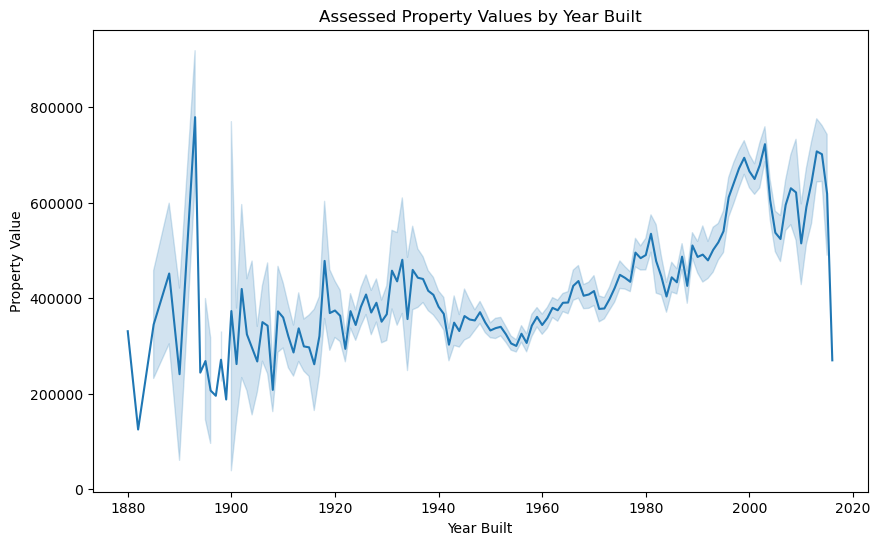

In [16]:
e.get_qfour_chart(tr_smpl)

>Null Hypothesis (H0): There is NOT a significant difference in the assessed values of newer and older properties.

>Alternative Hypothesis (HA): There IS a significant difference in the assessed values of newer and older properties.

In [17]:
e.get_qfour_stats(tr_smpl)


t-test - p-value: 0.0
We reject the null hypothesis



### Summary:

The age of a house has a significant impact on its value. Newer houses are becoming more expensive while older ones are decreasing in value.

## MODELING

In [18]:
def outlier(df, feature, m=1.5):
    '''
    outlier will take in a dataframe's feature:
    - calculate it's 1st & 3rd quartiles,
    - use their difference to calculate the IQR
    - then apply to calculate upper and lower bounds
    - using the `m` multiplier
    '''
    q1 = df[feature].quantile(.25)
    q3 = df[feature].quantile(.75)
    
    iqr = q3 - q1
    
    multiplier = m
    upper_bound = q3 + (multiplier * iqr)
    lower_bound = q1 - (multiplier * iqr)
    
    return upper_bound, lower_bound

In [19]:
upper_bound, lower_bound = outlier(tr_smpl, 'bedrooms')
upper_bound


5.5

In [20]:
lower_bound

1.5

In [21]:
X_tr, X_val, X_ts, y_tr, y_val, y_ts, to_scale, baseline = m.get_Xs_ys_to_scale_baseline(tr, val, ts, target)

In [22]:
X_tr_sc, X_val_sc, X_ts_sc = m.scale_data(X_tr,X_val,X_ts,to_scale)

In [31]:
metrics_df = m.get_models_dataframe(baseline,tr,y_tr,y_val,y_ts,X_tr_sc,X_val_sc,X_ts_sc)
metrics_df

,model,rmse,r2
0,baseline,287521.300864,0.000000
1,ols+RFE,242845.976244,0.289969
2,ols,240980.584354,0.300835
3,lars,240979.182989,0.300843
4,poly_2D,235231.671299,0.333796
5,glm,245291.392203,0.275597
6,test,234757.177189,0.345850
